In [149]:
# 引用用到的文件
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

print("引用文件成功")

引用文件成功


In [150]:
# 加载数据
data = pd.read_excel('./data/cleaned_data.xlsx', sheet_name='Sheet1')

In [151]:
# 加载数据和标签
X = data.drop(columns=["label"])
Y = data["label"]

In [152]:
# 将标签转化为整型
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)

In [153]:
# 将数据变为标准差
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [154]:
# 划分数据集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, stratify=y)

In [155]:
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# 特征选择（基于 XGBoost 特征重要性）
xgb_for_feature_selection = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=6,
    learning_rate=0.1,
    n_estimators=800
)
selector = SelectFromModel(xgb_for_feature_selection, threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)

# 数据增强（处理类别不平衡）
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# 定义优化后的基模型
base_learners = [
    ('xgb', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        max_depth=5,  # 降低深度
        learning_rate=0.05,  # 降低学习率
        n_estimators=1000,  # 增加树的数量
        min_child_weight=3,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.2,  # 增加正则化
        alpha=0.1,  # 增加 L1 正则化
        reg_lambda=2  # 增加 L2 正则化
    )),
    ('rf', RandomForestClassifier(
        n_estimators=300,  # 增加树的数量
        max_depth=8,  # 限制树的深度
        min_samples_split=5,  # 调整最小样本数
        min_samples_leaf=3,
        max_features='log2',  # 调整特征选择
        class_weight='balanced'
    ))
]

# 定义元学习器（使用逻辑回归）
meta_learner = LogisticRegression()

# 使用 StackingClassifier 构建模型
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 交叉验证
scores = cross_val_score(stacking_model, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"交叉验证准确率: {scores.mean():.4f} ± {scores.std():.4f}")

交叉验证准确率: 0.9032 ± 0.0509


In [156]:
# 训练模型
eval_set = [(X_test, y_test)]
stacking_model.fit(X_train, y_train)

# 处理测试集数据（添加以下代码）
X_test_selected = selector.transform(X_test)  # 应用特征选择器
X_test_scaled = scaler.transform(X_test_selected)  # 应用训练集的标准化器


In [157]:
# 获取基模型的特征重要性
base_models = stacking_model.estimators_
feature_importances = []

for model in base_models:
    if hasattr(model, 'feature_importances_'):
        feature_importances.append(model.feature_importances_)
    else:
        print(f"Model does not have feature_importances_")

# 如果有多个基模型，计算平均特征重要性
if feature_importances:
    avg_feature_importances = np.mean(feature_importances, axis=0)
else:
    print("No feature_importances_ available from the base models.")
    avg_feature_importances = None

# 获取特征名称
feature_names = X.columns

# 获取top10并进行打印
if avg_feature_importances is not None:
    top_features_idx = avg_feature_importances.argsort()[-10:][::-1]
    top_feature_name = [feature_names[i] for i in top_features_idx]
    print("Top 10 Features:", top_feature_name)
else:
    print("Cannot compute top features due to missing feature_importances_.")


Top 10 Features: ['Gender', '661.0686__496.07', '659.5677__495.82', '659.0663__495.82', '529.3028__44.31', '697.0139__495.82', '654.3022__36.15', '644.4339__397.51', '721.0651__495.08', '514.3122__240.75']


In [158]:
# 预测训练集和测试集
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

# 计算准确率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"训练集准确率: {train_accuracy:.4f}")
print(f"测试集准确率: {test_accuracy:.4f}")

训练集准确率: 1.0000
测试集准确率: 0.8936


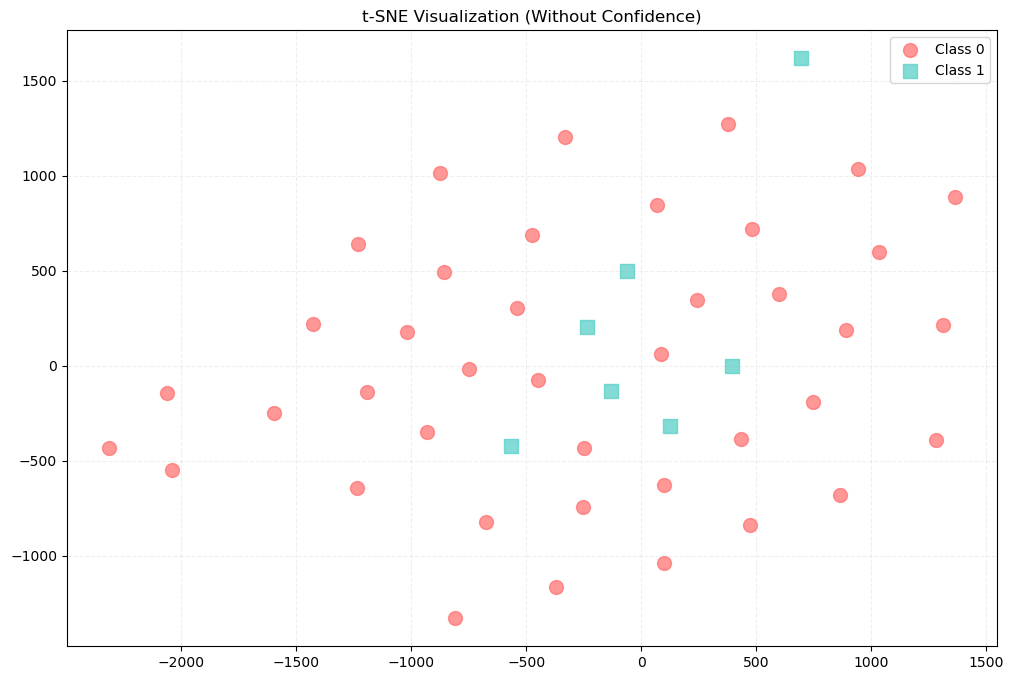

In [159]:
# 定义颜色和标记
colors = ['#FF6B6B', '#4ECDC4']
markers = ['o', 's']

# 直接使用t-SNE进行降维
tsne = TSNE(
    n_components=2,
    perplexity=30,  # 尝试不同的perplexity值
    n_iter=10000,
    learning_rate=500
)

X_tsne = tsne.fit_transform(X_test_scaled)

# 绘制t-SNE可视化图
plt.figure(figsize=(12, 8))
for i, label in enumerate(np.unique(y_test_pred)):
    mask = y_test_pred == label
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=[colors[i]], marker=markers[i],
                label=f'Class {label}', alpha=0.7, s=100)

plt.title('t-SNE Visualization (Without Confidence)')
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()
plt.show()

In [161]:
# 导入所需的额外库
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 存储多次运行的结果
all_results = {
    '训练集准确率': [], '测试集准确率': [],
    '去除top10后训练集准确率': [], '去除top10后测试集准确率': [],
    '去除top20后训练集准确率': [], '去除top20后测试集准确率': [],
    '5折交叉验证准确率': [],
    'top10特征': [], 'top20特征': []
}

# 运行10次评估
for run in range(10):
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2)
    
    # 特征选择
    xgb_for_feature_selection = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        max_depth=6,
        learning_rate=0.1,
        n_estimators=800
    )
    xgb_for_feature_selection.fit(X_train, y_train)
    
    # 获取特征重要性
    feature_importance = xgb_for_feature_selection.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # 保存top特征
    all_results['top10特征'].append(importance_df['feature'].head(10).tolist())
    all_results['top20特征'].append(importance_df['feature'].head(20).tolist())
    
    # 训练原始模型
    stacking_model.fit(X_train, y_train)
    train_pred = stacking_model.predict(X_train)
    test_pred = stacking_model.predict(X_test)
    
    all_results['训练集准确率'].append(accuracy_score(y_train, train_pred))
    all_results['测试集准确率'].append(accuracy_score(y_test, test_pred))
    
    # 去除top10特征
    top10_features = importance_df['feature'].head(10).tolist()
    X_train_no_top10 = np.delete(X_train, [list(feature_names).index(f) for f in top10_features], axis=1)
    X_test_no_top10 = np.delete(X_test, [list(feature_names).index(f) for f in top10_features], axis=1)
    
    stacking_model.fit(X_train_no_top10, y_train)
    train_pred_no_top10 = stacking_model.predict(X_train_no_top10)
    test_pred_no_top10 = stacking_model.predict(X_test_no_top10)
    
    all_results['去除top10后训练集准确率'].append(accuracy_score(y_train, train_pred_no_top10))
    all_results['去除top10后测试集准确率'].append(accuracy_score(y_test, test_pred_no_top10))
    
    # 去除top20特征
    top20_features = importance_df['feature'].head(20).tolist()
    X_train_no_top20 = np.delete(X_train, [list(feature_names).index(f) for f in top20_features], axis=1)
    X_test_no_top20 = np.delete(X_test, [list(feature_names).index(f) for f in top20_features], axis=1)
    
    stacking_model.fit(X_train_no_top20, y_train)
    train_pred_no_top20 = stacking_model.predict(X_train_no_top20)
    test_pred_no_top20 = stacking_model.predict(X_test_no_top20)
    
    all_results['去除top20后训练集准确率'].append(accuracy_score(y_train, train_pred_no_top20))
    all_results['去除top20后测试集准确率'].append(accuracy_score(y_test, test_pred_no_top20))
    
    # 5折交叉验证
    cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5)
    all_results['5折交叉验证准确率'].append(cv_scores.mean())

# 打印结果表格
print("=== 模型性能结果表 ===")
print(" 次数  训练集准确率   测试集准确率  去除top10后训练集准确率  去除top10后测试集准确率  去除top20后训练集准确率  去除top20后测试集准确率  5折交叉验证准确率")
for i in range(10):
    print(f"{i+1:3d}    {all_results['训练集准确率'][i]:.6f} {all_results['测试集准确率'][i]:.6f}    {all_results['去除top10后训练集准确率'][i]:.6f}    {all_results['去除top10后测试集准确率'][i]:.6f}    {all_results['去除top20后训练集准确率'][i]:.6f}    {all_results['去除top20后测试集准确率'][i]:.6f}    {all_results['5折交叉验证准确率'][i]:.6f}")

print("\n平均值    ", end="")
for metric in ['训练集准确率', '测试集准确率', '去除top10后训练集准确率', '去除top10后测试集准确率', 
               '去除top20后训练集准确率', '去除top20后测试集准确率', '5折交叉验证准确率']:
    print(f"{np.mean(all_results[metric]):.6f}    ", end="")

# 特征重要性统计
print("\n\n=== 特征出现次数统计 ===")
all_top10 = [item for sublist in all_results['top10特征'] for item in sublist]
all_top20 = [item for sublist in all_results['top20特征'] for item in sublist]

top10_counts = pd.Series(all_top10).value_counts()
top20_counts = pd.Series(all_top20).value_counts()

print("       Top10特征名称 Top10出现次数        Top20特征名称 Top20出现次数")
for (f10, c10), (f20, c20) in zip(top10_counts.items(), top20_counts.items()):
    print(f"{f10:>15} {c10:>10}    {f20:>15} {c20:>10}")

# 特征聚类和相关性分析
important_features = top20_counts.index
X_important = X_scaler[:, [list(X.columns).index(f) for f in important_features]]

# 聚类分析
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_important.T)
    score = silhouette_score(X_important.T, cluster_labels)
    silhouette_scores.append(score)

optimal_clusters = np.argmax(silhouette_scores) + 2
print(f"\n根据手肘法分析，建议的最佳聚类数为: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters)
cluster_labels = kmeans.fit_predict(X_important.T)

print("\n特征聚类结果:")
for i in range(optimal_clusters):
    cluster_features = important_features[cluster_labels == i]
    print(f"\n聚类 {i+1}:")
    print(", ".join(cluster_features))

# 相关性分析
corr_matrix = np.corrcoef(X_important.T)
print("\n高相关性特征对 (|相关系数| > 0.7):")
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix[i,j]) > 0.7:
            print(f"{important_features[i]} 和 {important_features[j]}: {corr_matrix[i,j]:.3f}")

=== 模型性能结果表 ===
 次数  训练集准确率   测试集准确率  去除top10后训练集准确率  去除top10后测试集准确率  去除top20后训练集准确率  去除top20后测试集准确率  5折交叉验证准确率
  1    1.000000 0.914894    1.000000    0.936170    1.000000    0.914894    0.810811
  2    1.000000 0.787234    1.000000    0.808511    1.000000    0.829787    0.859459
  3    0.994595 0.914894    1.000000    0.893617    1.000000    0.872340    0.832432
  4    1.000000 0.851064    1.000000    0.851064    1.000000    0.787234    0.827027
  5    1.000000 0.872340    0.994595    0.851064    0.994595    0.872340    0.837838
  6    1.000000 0.723404    1.000000    0.787234    1.000000    0.765957    0.848649
  7    1.000000 0.808511    0.994595    0.787234    1.000000    0.829787    0.864865
  8    1.000000 0.914894    1.000000    0.914894    1.000000    0.936170    0.832432
  9    1.000000 0.893617    1.000000    0.893617    1.000000    0.893617    0.816216
 10    1.000000 0.893617    1.000000    0.893617    1.000000    0.893617    0.821622

平均值    0.999459    0.857447    0.9989